In [1]:
# Importing necessary libraries.
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdDepictor import Compute2DCoords
from io import StringIO
import mols2grid
import tqdm

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

from chembl_webresource_client.new_client import new_client

from scaffold_finder import generate_fragments, find_scaffolds, get_molecules_with_scaffold, cleanup_fragment

In [2]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [3]:
# Get UniProt ID of the target of interest (Colorectal cancer) from UniProt website.

uniprot_id = "P11511"

# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')


The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [4]:
# Download target data from ChEMBL.
targets = pd.DataFrame.from_records(targets)
targets


,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Cytochrome P450 19A1,CHEMBL1978,SINGLE PROTEIN
1,Homo sapiens,Cytochrome P450 19A1,CHEMBL1978,SINGLE PROTEIN


In [5]:
# Select target (target ChEMBL ID)
target = targets.iloc[0]
target

organism                    Homo sapiens
pref_name           Cytochrome P450 19A1
target_chembl_id              CHEMBL1978
target_type               SINGLE PROTEIN
Name: 0, dtype: object

In [6]:
#Save selected ChEMBL ID.
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL1978


### Get bioactivity data.

Now, we want to query bioactivity data for the target of interest.
Fetch bioactivity data for the target from ChEMBL.

In this step, we fetch the bioactivity data and filter it to only consider

    human proteins,
    bioactivity type IC50,
    exact measurements (relation '='), 
    binding data (assay type 'B').


In [7]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length of bioactivities object: {len(bioactivities)}")


Length of bioactivities object: 2376


In [8]:
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()


DataFrame shape: (2376, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,82585,CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,CHEMBL341591,=,nM,7100.0,CHEMBL1978,Homo sapiens,IC50,uM,7.1
1,112960,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL431859,=,nM,238.0,CHEMBL1978,Homo sapiens,IC50,uM,0.238
2,116766,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL113637,=,nM,57.0,CHEMBL1978,Homo sapiens,IC50,uM,0.057
3,118017,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL112021,=,nM,54.0,CHEMBL1978,Homo sapiens,IC50,uM,0.054
4,118020,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL324070,=,nM,5400.0,CHEMBL1978,Homo sapiens,IC50,uM,5.4


In [9]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,82585,CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,CHEMBL341591,=,nM,7100.0,CHEMBL1978,Homo sapiens,IC50
1,112960,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL431859,=,nM,238.0,CHEMBL1978,Homo sapiens,IC50
2,116766,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL113637,=,nM,57.0,CHEMBL1978,Homo sapiens,IC50
3,118017,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL112021,=,nM,54.0,CHEMBL1978,Homo sapiens,IC50
4,118020,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL324070,=,nM,5400.0,CHEMBL1978,Homo sapiens,IC50


Preprocess and filter bioactivity data.

In [10]:
# 1. Convert datatype of “standard_value” from “object” to “float”.

In [11]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [12]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes


activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [13]:
# 2. Delete entries with missing values.
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2376, 11)


In [14]:
#3. Keep only entries with “standard_unit == nM”.
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [15]:
# 4. Delete duplicate molecules.
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (1799, 11)


In [16]:
# 5. Reset “DataFrame” index.
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,82585,CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,CHEMBL341591,=,nM,7100.0,CHEMBL1978,Homo sapiens,IC50
1,112960,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL431859,=,nM,238.0,CHEMBL1978,Homo sapiens,IC50
2,116766,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL113637,=,nM,57.0,CHEMBL1978,Homo sapiens,IC50
3,118017,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL112021,=,nM,54.0,CHEMBL1978,Homo sapiens,IC50
4,118020,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL324070,=,nM,5400.0,CHEMBL1978,Homo sapiens,IC50


In [17]:
# 6. Rename columns.
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True)

bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,82585,CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,CHEMBL341591,=,nM,7100.0,CHEMBL1978,Homo sapiens,IC50
1,112960,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL431859,=,nM,238.0,CHEMBL1978,Homo sapiens,IC50
2,116766,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL113637,=,nM,57.0,CHEMBL1978,Homo sapiens,IC50
3,118017,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL112021,=,nM,54.0,CHEMBL1978,Homo sapiens,IC50
4,118020,CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,CHEMBL324070,=,nM,5400.0,CHEMBL1978,Homo sapiens,IC50


### Get compound data.

We have a DataFrame containing all molecules tested measured bioactivity.

Now, we want to get the molecular structures of the molecules that are linked to respective bioactivity ChEMBL IDs.

fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [18]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")


In [19]:
# Download compound data from ChEMBL.
compounds = list(tqdm(compounds_provider))

compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")


  0%|          | 0/1799 [00:00<?, ?it/s]

DataFrame shape: (1799, 2)


In [20]:
compounds_df

,molecule_chembl_id,molecule_structures
0,CHEMBL28,{'canonical_smiles': 'O=c1cc(-c2ccc(O)cc2)oc2c...
1,CHEMBL7162,{'canonical_smiles': 'CS(=O)(=O)Nc1ccc([N+](=O...
2,CHEMBL268918,{'canonical_smiles': 'CCCCCCC[C@@H]1CC2C(CCC3(...
3,CHEMBL50,{'canonical_smiles': 'O=c1c(O)c(-c2ccc(O)c(O)c...
4,CHEMBL8333,{'canonical_smiles': 'CCC[C@H]1CC2C(CCC3(C)C(=...
...,...,...
1794,CHEMBL5195433,{'canonical_smiles': 'Cc1c(-c2nocc2C(=O)SC#N)c...
1795,CHEMBL5197552,{'canonical_smiles': 'C#CCOc1ccc2cc(C(c3ccc(Cl...
1796,CHEMBL5203413,{'canonical_smiles': 'CC#CCOc1ccc2cc(C(c3ccc(C...
1797,CHEMBL5204674,{'canonical_smiles': 'CCC#CCOc1ccc2oc(C(c3ccc(...


### Preprocess and filter compound data.

In [21]:
# 1. Remove entries with missing molecule structure entry.

compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1799, 2)


In [22]:
# 2. Delete duplicate molecules.

compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1799, 2)


In [23]:
# 3. Get molecules with canonical SMILES.

canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1799, 2)


In [24]:
# 4. Sanity check: Remove all molecules without a canonical SMILES string.

compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1799, 2)


In [25]:
# Merge both datasets, compound and bioactivity data.
    
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")



Dataset with 1799 entries.


In [26]:
output_df.head(2)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL341591,7100.0,nM,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12
1,CHEMBL431859,238.0,nM,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21


In [27]:
output_df = output_df[output_df.IC50 != 0]
output_df.shape

(1798, 4)

In [28]:
# Add PIC50 values.

def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value


output_df["PIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

output_df.head(2)

,molecule_chembl_id,IC50,units,smiles,PIC50
0,CHEMBL341591,7100.0,nM,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,5.148742
1,CHEMBL431859,238.0,nM,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,6.623423


In [30]:
output_df.PIC50.min(), output_df.PIC50.max()

(3.1095789811990855, 10.823908740944319)

array([[<Axes: title={'center': 'PIC50'}>]], dtype=object)

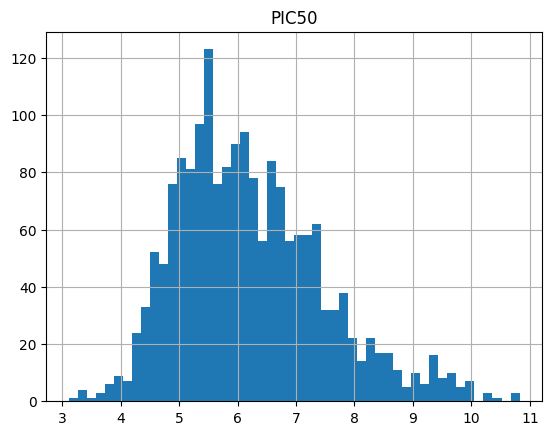

In [33]:
output_df.hist(column="PIC50", bins= 50)

#### Add a column for RDKit molecule objects to our DataFrame and look at the structures of the molecules with the highest pIC50 values.

In [35]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

# Sort molecules by pIC50
output_df.sort_values(by="PIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

output_df.head()

,molecule_chembl_id,IC50,units,smiles,PIC50,ROMol
0,CHEMBL1672980,0.015,nM,COc1ccc(-c2cc(N(Cc3ccc(OS(N)(=O)=O)cc3)n3cnnc3...,10.823909,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...
1,CHEMBL1672978,0.015,nM,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Cl)c2)n2cnnc2)...,10.823909,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...
2,CHEMBL1672979,0.018,nM,N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Br)c2)n2cnnc2)...,10.744727,<rdkit.Chem.rdchem.Mol object at 0x0000023573B...
3,CHEMBL310735,0.037,nM,C[C@H]1CC2C3CCC(=O)C3(C)CCC2C2(C)CCCC=C12,10.431798,<rdkit.Chem.rdchem.Mol object at 0x0000023573D...
4,CHEMBL305205,0.049,nM,C[C@@H]1CC2C3CCC(=O)C3(C)CCC2C2(C)CCCC=C12,10.309804,<rdkit.Chem.rdchem.Mol object at 0x0000023573D...


In [37]:
output_df.to_csv("Aromatase_bioactivity_and_drugs", index= False)